In [10]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


# Load Data

In [11]:
Data = pd.read_csv('TrainData.csv', encoding = "ISO-8859-1" )

In [12]:
#pip install sklearn

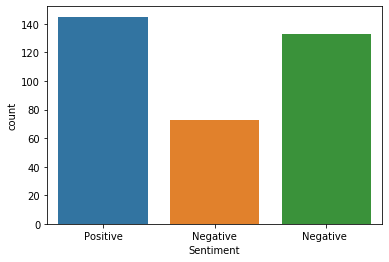

In [13]:
import seaborn as sns

sns.countplot(x='Sentiment', data=Data)

In [14]:
Data['Sentiment'].value_counts()

Positive     145
Negative     133
Negative      73
Name: Sentiment, dtype: int64

In [15]:
Data['Sentiment'].unique()

array(['Positive', 'Negative', 'Negative '], dtype=object)

In [16]:
Data.Sentiment.replace({"Negative ":"Negative"},inplace=True)

In [17]:
Data['Sentiment'] = Data['Sentiment'].fillna(Data['Sentiment'].mode()[0])

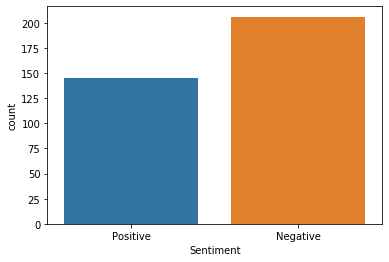

In [88]:
sns.countplot(x='Sentiment', data=Data)

In [18]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [19]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [20]:
x = []
sentences = list(Data['Review'])
for sen in sentences:
    x.append(preprocess_text(sen))

In [21]:
y = Data['Sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

# Train Test Split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [23]:
#Word to Index Dictionary by using Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [24]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [25]:
x_train

array([[ 73,  67,  60, ...,   0,   0,   0],
       [ 16, 185, 417, ...,   0,   0,   0],
       [126,   2,  33, ...,   0,   0,   0],
       ...,
       [  1,   3, 230, ...,   0,   0,   0],
       [ 76, 112, 408, ...,   0,   0,   0],
       [283, 128, 851, ...,   0,   0,   0]])

# GloVe embeddings to create feature matrix

In [26]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.sample.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [27]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Creating a Simple Neural Network

In [28]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          179000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 20001     
Total params: 199,001
Trainable params: 20,001
Non-trainable params: 179,000
_________________________________________________________________
None


In [30]:
history = model.fit(x_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 224 samples, validate on 56 samples
Epoch 1/6
224/224 [==============================] - 0s 1ms/step - loss: 0.6800 - acc: 0.4777 - val_loss: 0.4291 - val_acc: 0.8929
Epoch 2/6
224/224 [==============================] - 0s 135us/step - loss: 0.3547 - acc: 0.9554 - val_loss: 0.3213 - val_acc: 1.0000
Epoch 3/6
224/224 [==============================] - 0s 117us/step - loss: 0.2480 - acc: 1.0000 - val_loss: 0.2733 - val_acc: 1.0000
Epoch 4/6
224/224 [==============================] - 0s 125us/step - loss: 0.1989 - acc: 1.0000 - val_loss: 0.2455 - val_acc: 1.0000
Epoch 5/6
224/224 [==============================] - 0s 115us/step - loss: 0.1719 - acc: 1.0000 - val_loss: 0.2267 - val_acc: 1.0000
Epoch 6/6
224/224 [==============================] - 0s 120us/step - loss: 0.1528 - acc: 1.0000 - val_loss: 0.2127 - val_acc: 1.0000


In [31]:
score = model.evaluate(x_test, y_test, verbose=1)

71/71 [==============================] - 0s 120us/step


In [32]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2113468741447153
Test Accuracy: 1.0


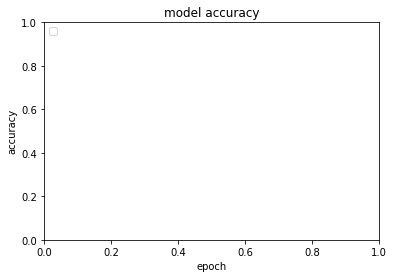

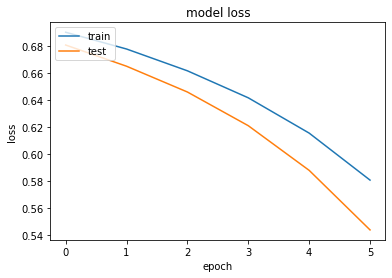

In [87]:
import matplotlib.pyplot as plt

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [40]:
from tensorflow.keras.layers import LSTM

In [41]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout
from keras.layers import BatchNormalization
from keras.layers import *
from keras.models import Sequential

In [42]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout, Flatten,Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from keras import optimizers



In [51]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

In [ ]:
#     model = Sequential()
#    model.add(embedding_layer)
#    model.add(LSTM(20, return_sequences = True))
#    model.add(Dense(1, activation='sigmoid'))
#   adam = optimizers.Adam(lr = 0.001)
#  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   


In [81]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(20, return_sequences = True))
model.add(LSTM(20, return_sequences = True))
model.add(LSTM(20, return_sequences = False))
model.add(Dense(1, activation='sigmoid'))
    
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['acc'])

In [82]:
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          179000    
_________________________________________________________________
lstm_18 (LSTM)               (None, 200, 20)           9680      
_________________________________________________________________
lstm_19 (LSTM)               (None, 200, 20)           3280      
_________________________________________________________________
lstm_20 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 195,261
Trainable params: 16,261
Non-trainable params: 179,000
_________________________________________________________________
None


In [83]:
history = model.fit(x_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 224 samples, validate on 56 samples
Epoch 1/6
224/224 [==============================] - 3s 12ms/step - loss: 0.6905 - acc: 0.9866 - val_loss: 0.6810 - val_acc: 1.0000
Epoch 2/6
224/224 [==============================] - 1s 4ms/step - loss: 0.6781 - acc: 1.0000 - val_loss: 0.6653 - val_acc: 1.0000
Epoch 3/6
224/224 [==============================] - 1s 4ms/step - loss: 0.6619 - acc: 1.0000 - val_loss: 0.6461 - val_acc: 1.0000
Epoch 4/6
224/224 [==============================] - 1s 3ms/step - loss: 0.6418 - acc: 1.0000 - val_loss: 0.6211 - val_acc: 1.0000
Epoch 5/6
224/224 [==============================] - 1s 4ms/step - loss: 0.6156 - acc: 1.0000 - val_loss: 0.5879 - val_acc: 1.0000
Epoch 6/6
224/224 [==============================] - 1s 4ms/step - loss: 0.5807 - acc: 1.0000 - val_loss: 0.5437 - val_acc: 1.0000


In [84]:
score = model.evaluate(x_test, y_test, verbose=1)

71/71 [==============================] - 0s 2ms/step


In [85]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.546382659757641
Test Accuracy: 1.0


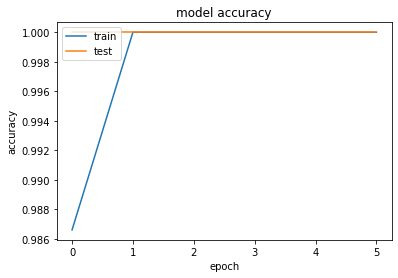

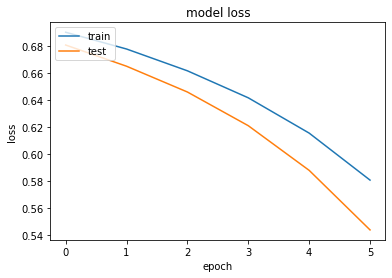

In [86]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()